# Example Usage of RCLVatlas

Lexi Jones

Last edited: 12/19/22

To run this example:
1. Download geostrophic velocity CMEMS data from 2019/09/30 - 2019/10/24
2. Setup the config.py file with the following params (default):
- grid_bounds = {
               'lon_bound_west':199.0,
               'lon_bound_east':204.0,
               'lat_bound_south':17.0,
               'lat_bound_north':22.0,
               'lag_grid_res':0.03125
               }

- sim_params = {
              'runtime':8, 
              'runtime_unit':'days',
              'timestep':20, 
              'output_freq':6,
              'backwards':'y'
              } 

- RCLV_params = {
               'min_dist':24,
               'min_area':104,
               'init_contour_step_frac':0.1,
               'convex_def_tol':0.001
               }

3. Run the following lines in the command line to simulate the Lagrangian trajectories and calculate the Lagrangian averaged vorticity deviation (LAVD)
- `python run_parcels_CMEMS.py 20191008`
- `python run_parcels_CMEMS.py 20191016`
- `python run_parcels_CMEMS.py 20191024`

At this point, you will have 3 8-day backward-in-time Lagrangian trajectories calculated for a 5x5 degree box near Hawaii. You will also have the LAVD calculated for each of these runs, which will be used to identify RCLVs. 

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from config import *

sys.path.append('./RCLVatlas')
from subfunctions_for_RCLV_atlas import read_RCLV_CSV_untracked,read_RCLV_CSV_tracked,save_RCLV_CSV
from mainfunctions_for_RCLV_atlas import *

Set up date list

In [2]:
dates = [filename[0:8] for filename in os.listdir(LAVD_dir)]
date_list = np.sort(np.unique(dates)).tolist()[::-1] #Reverse the order because we will iterate from the latest date to the earliest
date_list

['20020315']

Preview LAVD output

In [3]:
LAVD_output_file_path = LAVD_dir + date_list[0] + '_LAVD_' + filename_str + '.npy'
LAVD = np.load(LAVD_output_file_path)
LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))

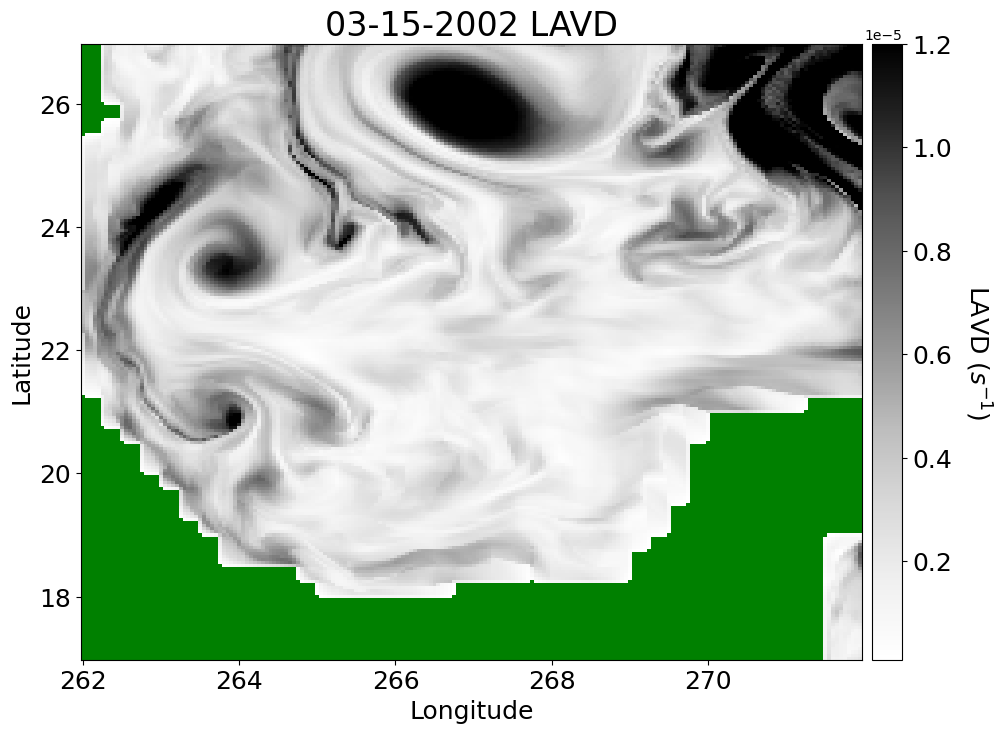

In [4]:
fontsize = 18

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_facecolor("g")
plot = ax.pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));

cbar = plt.colorbar(plot, pad = 0.01)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('LAVD $(s^{-1})$', rotation=270, fontsize=fontsize)
    
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('%s-%s-%s LAVD'%(date_list[0][4:6],date_list[0][6:8],date_list[0][0:4]),fontsize=24)

plt.show()

Identify RCLVs

In [5]:
RCLV_data = np.array(set_up_RCLV_atlas(date_list),dtype=object) 
print('Length of RCLV_data: %s'%(len(RCLV_data)))
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0])) #save RCLV as CSV

Identifying RCLVs...
20020315


/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


Length of RCLV_data: 1


In [8]:
# lag_traj_dir = './lag_trajs/'
# initial_date = 20020315

In [6]:
traj = xr.open_dataset("/home/b/b382618/RCLVatlas_stella/lag_trajs/20020315_10days_runtime_20min_timestep_particle_start_lat_17.0_27.0_lon_262.0_272.0_spatial_step_0.05_6hr_output_freq.zarr")

/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/b/b382618/.conda/envs/parcels2/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [7]:
LAVD_reshape.data

array([[           nan,            nan,            nan, ...,
        1.94895336e-06, 2.01557298e-06, 2.32277345e-06],
       [           nan,            nan,            nan, ...,
        1.68040877e-06, 1.70543959e-06, 1.95435074e-06],
       [           nan,            nan,            nan, ...,
        1.23350228e-06, 1.40718076e-06, 1.69638834e-06],
       ...,
       [           nan,            nan,            nan, ...,
        1.48247200e-05, 1.52984175e-05, 1.52063857e-05],
       [           nan,            nan,            nan, ...,
        1.43478490e-05, 1.42136789e-05, 1.45128113e-05],
       [           nan,            nan,            nan, ...,
        1.36555210e-05, 1.31842221e-05, 1.35843282e-05]])

In [8]:
## Stella- now that I have correct lavd fields I will try to use texas guys xlcs 
# rclv id methods
sys.path.append("/home/b/b382618/xlcs_stella1/xlcs/")

import lagrangian_tools as lt
import grid_calc
# from custommap import *
from contours import extract_contours

In [9]:
# parameters
defTol = 0.075  # [%] control the deficiency of the loop closer to 0 means perfectly convex (no filamentation)
max_radius = 3  # degree (so ~300 km)

# try extracting contours around each identified peaks
# number_levels represents the number of "test" contour between [0, peak_lavd_value]
number_levels = 50
peaks_xy, peaks_contour = extract_contours(LAVD_reshape, defTol, max_radius, number_levels)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [12]:
print(RCLV_data[0]) # header
# print(RCLV_data[1]) # example RCLV 

['Date' 'RCLV ID' 'Orientation' 'Age (days)' 'Area (km^2)' 'Center Lon'
 'Center Lat' 'CD' 'flag' 'Boundary Coords']


'Date'

Track RCLVs through time

In [8]:
RCLV_data = np.array(read_RCLV_CSV_untracked('%sRCLV_%s_%s_untracked.csv'%(RCLV_dir,date_list[-1],date_list[0]),1),dtype=object)
RCLV_data = track_and_ID_RCLVs(RCLV_data,date_list)
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the tracked data as a CSV

Tracking eddies through time & IDing...
Number of identical contours to remove: 0
20020315


FileNotFoundError: [Errno 2] No such file or directory: '/home/b/b382618/RCLVatlas_stella/lag_trajs/20020315_10days_runtime_20min_timestep_particle_start_lat_17.0_27.0_lon_262.0_272.0_spatial_step_0.05_6hr_output_freq.nc'

QC skip step

In [8]:
log_file = open('%sRCLV_%s_%s_log_file.txt'%(RCLV_dir,date_list[-1],date_list[0]),'a')
RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_tracked_with_ID.csv'%(RCLV_dir,date_list[-1],date_list[0]))    
RCLV_data = interpolate_skipped_contours(RCLV_data,log_file,date_list)
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))

Checking if any RCLVs skipped a date...


./RCLVatlas/mainfunctions_for_RCLV_atlas.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  RCLV_data_no_header = np.array(RCLV_data)[1:]


Age the contours

In [9]:
RCLV_data = read_RCLV_CSV_tracked('%sRCLV_%s_%s_skips_interpolated.csv'%(RCLV_dir,date_list[-1],date_list[0]))
RCLV_data = age_RCLVs(RCLV_data)
save_RCLV_CSV(RCLV_data,'%sRCLV_%s_%s_atlas.csv'%(RCLV_dir,date_list[-1],date_list[0])) # Save the final dataset
RCLV_data = np.array(RCLV_data,dtype=object)

Giving RCLVs an age & saving the final atlas...


In [10]:
for r in RCLV_data:
    print(r[0:9])

['Date', 'RCLV ID', 'Orientation', 'Age (days)', 'Area (km^2)', 'Center Lon', 'Center Lat', 'CD', 'flag']
['20191024', 1, 'cyc', 24, 14465.050807772293, 202.40625, 19.875, 0.010385947132175208, 0.0]
['20191024', 2, 'anti', 24, 15622.8876144537, 200.71875, 18.28125, 0.029652894812879194, 0.0]
['20191016', 1, 'cyc', 16, 11869.603213112541, 202.625, 19.84375, 0.020256992386499563, 0.0]
['20191016', 2, 'anti', 16, 14278.583594907841, 201.4375, 18.34375, 0.027154415813407724, 0.0]
['20191008', 1, 'cyc', 8, 8516.177371859932, 202.96875, 19.9375, 0.01491425250602246, 0.0]
['20191008', 2, 'anti', 8, 12661.06795052839, 201.9375, 18.46875, 0.02885829251570875, 0.0]
['20191008', 3, 'cyc', 8, 4589.9889770806085, 201.5625, 20.625, 0.02972379996395669, 0.0]
['20191008', 4, 'cyc', 8, 9473.864969592372, 199.875, 21.0625, 0.026477928570795114, 0.0]


Overlay the RCLVs on the LAVD fields

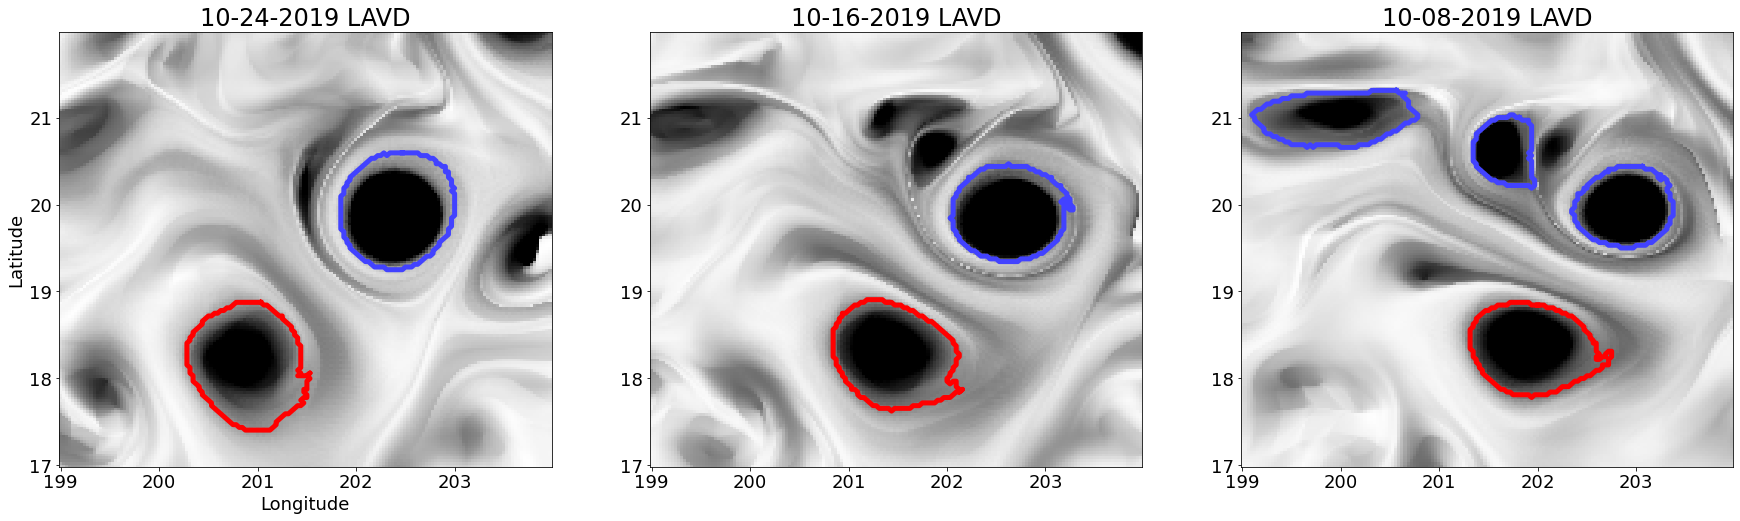

In [11]:
fontsize = 18
fig,ax = plt.subplots(1,3,figsize=(30,8))

ax[0].set_xlabel('Longitude',fontsize=fontsize)
ax[0].set_ylabel('Latitude',fontsize=fontsize)

c = 0
for date in date_list:
    # Load the LAVD data
    LAVD_output_file_path = LAVD_dir + date + '_LAVD_' + filename_str + '.npy'
    LAVD = np.load(LAVD_output_file_path)
    LAVD = np.ma.masked_where(np.isnan(LAVD),LAVD) #Land mask required for the peak_local_max function to work
    LAVD_reshape = np.transpose(np.reshape(LAVD,(len(traj_lon_array),len(traj_lat_array))))
    
    # Plot the LAVD 
    plot = ax[c].pcolormesh(traj_lon_array,traj_lat_array,LAVD_reshape,shading='nearest',cmap='Greys',vmin=10**(-7), vmax=1.2*(10**(-5)));
    ax[c].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[c].set_title('%s-%s-%s LAVD'%(date[4:6],date[6:8],date[0:4]),fontsize=24)

    # Plot the RCLVs for the given date
    RCLV_data_this_day = RCLV_data[np.where([r[0]==date for r in RCLV_data])[0]]
    RCLV_bnds = [r[9:] for r in RCLV_data_this_day] # boundary coordinates
    RCLV_orientations = [r[2] for r in RCLV_data_this_day] # eddy polarity
    
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]

        if RCLV_orientations[i] == 'anti':
            color = '#FF0000'
        else:
            color = '#4242FF'
        ax[c].plot(x_bnds,y_bnds,linewidth=5,c=color)
    c += 1

plt.show()

Color by RCLV age

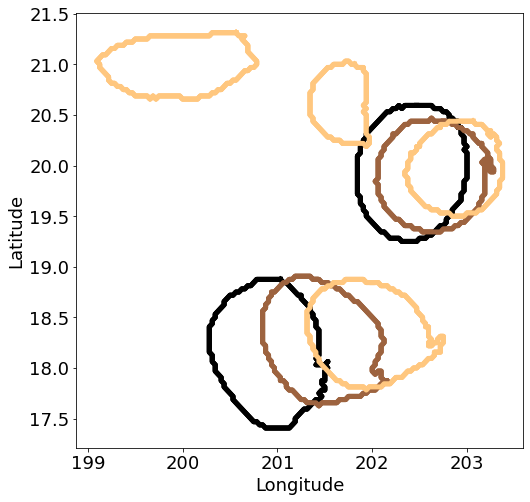

In [12]:
RCLV_bnds = [r[9:] for r in RCLV_data[1:]] # boundary coordinates
RCLV_ages = [r[3] for r in RCLV_data[1:]] # ages
norm = colors.Normalize(vmin=min(RCLV_ages), vmax=max(RCLV_ages))

fontsize = 18
fig,ax = plt.subplots(1,1,figsize=(8,8))

for date in date_list:
    for i in np.arange(0,len(RCLV_bnds)):
        x_bnds = [float(coord) for coord in RCLV_bnds[i][0::2]]
        y_bnds = [float(coord) for coord in RCLV_bnds[i][1::2]]
        ax.plot(x_bnds,y_bnds,linewidth=5,c=plt.cm.copper_r(norm(RCLV_ages[i])))
            
ax.set_xlabel('Longitude',fontsize=fontsize)
ax.set_ylabel('Latitude',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()